# Quantum Neural Networks

A Quantum Neural Network is built for a 2D CFD problem of determining the lift coefficient for varying angles of attack, $\alpha\in[0,15\degree]$. The tutorial below shows for a single feature (soon to be extended to multiple features).

## Install Necessary Libraries

Depending the environment manager, change the first command word to "mamba"/"conda"/"micromamba" for mamba users, miniconda/anaconda users and micromamba users respectively.

In [ ]:
!conda install pandas scipy scikit-learn -c conda-forge -y

## Import Necessary Libraries

In [1]:
from NoisyCircuits import QuantumCircuit as QC
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import pickle
import os
import json

2025-11-24 14:25:04,330	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Import and Pre-process Data

In [2]:
data = pd.read_csv("design_study_single_feature.csv", header=0)
X = data.iloc[:,0].values.reshape(-1, 1)
Y = data.iloc[:,-1].values.reshape(-1, 1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [4]:
x_train = x_train.flatten()
x_test = x_test.flatten()
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
beta_x = np.linalg.norm(x_train)
beta_y = np.linalg.norm(y_train)
x_train = x_train / beta_x
y_train = y_train / beta_y
x_test = x_test / beta_x
y_test = y_test / beta_y

## Initialize Quantum Circuit Instance with Noise

In [ ]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum token
backend_name = "ibm_fez"
num_qubits = 3
num_cores = 50
num_trajectories = 50
threshold = 1e-4
jsonize = True
verbose = True
qpu_type = "heron"
sim_backend = "pennylane" # Choose between "pennylane", "qulacs", and "qiskit"

Run the code below to get the latest calibration data from IBM hardware

In [7]:
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()

qiskit_runtime_service._discover_account:WARNING:2025-11-24 14:25:18,508: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-24 14:25:22,942: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-24 14:25:22,944: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-24 14:25:23,137: Using instance: Open_Sys, plan: open


Run the code below to use a sample noise model from IBM Hardware

In [8]:
if qpu_type == "eagle":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Eagle_QPU.pkl", "rb"))
elif qpu_type == "heron":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb"))
else:
    raise ValueError("Unsupported qpu_type. Supported types are 'eagle' and 'heron'.")

In [ ]:
nqc = QC(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores,
         backend_qpu_type=qpu_type, 
         num_trajectories=num_trajectories, 
         sim_backend=sim_backend,
         threshold=threshold, 
         jsonize=jsonize,
         verbose=verbose)

Completed Extraction of two-qubit gate Errors.
Starting post-processing on Single Qubit Errors.
Completed post-processing on Single Qubit Errors.
Processing two-qubit gate errors.
Qubit pair (0, 1): 18/48 errors above threshold (30 filtered out)
Qubit pair (1, 0): 18/48 errors above threshold (30 filtered out)
Qubit pair (1, 2): 18/48 errors above threshold (30 filtered out)
Qubit pair (2, 1): 18/48 errors above threshold (30 filtered out)
Two Qubit Gate errors processed.
Building Noise Operators for Two Qubit Gate Errors.
Completed building Noise Operators for Two Qubit Gate Errors.
Extracting Measurement Errors.
Available qubits in roerror_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88

## Running the QNN

### Build Quantum Circuit for Quantum Neural Network

Here, the original circuit is modified and the single feature is embedded across $3$ qubits.

In [10]:
def quantum_circuit_pure(weights, x_value):
    # Reset the quantum circuit
    nqc.refresh()
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute the circuit
    probs = nqc.run_pure_state(qubits=range(num_qubits))
    # Obtain the expectation value from the output probability distribution
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

In [11]:
def quantum_circuit_noisy(weights, x_value):
    nqc.refresh()
    total_layers = len(weights) // 3
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute circuit
    probs = nqc.execute(qubits=range(num_qubits), num_trajectories=50)
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

### Define Functions

Next we define the functions for predictions, loss function and accuracy functions

In [12]:
def predict(circuit_builder:callable,
            x_array:np.ndarray,
            weights:np.ndarray)->np.ndarray:
    predictions = [circuit_builder(weights, x) for x in x_array]
    return np.array(predictions)

def loss_function(circuit_builder:callable,
                  x_array:np.ndarray=x_train,
                  y_array:np.ndarray=y_train,
                  weights:np.ndarray=None)->float:
    predictions = predict(circuit_builder, x_array, weights)
    cost_mse = np.mean((predictions - y_array) ** 2) * beta_y**2
    return cost_mse

def accuracy_function(circuit_builder:callable,
                      x_array:np.ndarray=x_test,
                      y_array:np.ndarray=y_test,
                      weights:np.ndarray=None)->list[float]:
    predictions = predict(circuit_builder, x_array, weights) * beta_y
    rmse = root_mean_squared_error(y_array*beta_y, predictions)
    r2 = r2_score(y_array*beta_y, predictions)
    return [rmse, r2]

In [13]:
def cost_function(circuit_builder:callable,
                  weights_init:np.ndarray,
                  max_iter:int=100)->tuple[np.ndarray, list, list]:
    cost_list = []
    accuracy_list = []

    def objective(weights:np.ndarray,
                circuit_builder:callable)->float:
        global iteration
        loss = loss_function(circuit_builder, weights=weights)
        accuracy = accuracy_function(circuit_builder, weights=weights)
        iteration += 1
        print(f"Epoch: {iteration}\tLoss: {loss}\tRMSE: {accuracy[0]}\tR2: {accuracy[1]}")
        cost_list.append(loss)
        accuracy_list.append(accuracy)
        return loss
    
    opt = minimize(objective, x0=weights_init,
                   args=(circuit_builder,),
                   method="COBYLA", options={"maxiter": max_iter})
    weights = opt.x
    return (weights, cost_list, accuracy_list)

## Run the QNN

In [14]:
max_iter = 100
num_layers = 3
weights_init = np.random.uniform(-2*np.pi, 2*np.pi, size=(num_qubits*num_layers))

### Run the QNN with Pure Statevector Simulation

In [15]:
iteration = 0
weights_pure, cost_list_pure, accuracy_list_pure = cost_function(circuit_builder=quantum_circuit_pure,  
                                                                 weights_init=weights_init, 
                                                                 max_iter=max_iter)

Epoch: 1	Loss: 3.454830909866049	RMSE: 1.9319106692028563	R2: -12.10339292059022
Epoch: 2	Loss: 3.56994646458306	RMSE: 1.8946492544731053	R2: -11.602808255908469
Epoch: 3	Loss: 4.704595233082039	RMSE: 2.3111165559432707	R2: -17.752249796348806
Epoch: 4	Loss: 1.5483990197469788	RMSE: 1.480529052657062	R2: -6.695618858920884
Epoch: 5	Loss: 1.230861973443168	RMSE: 1.3097994910528221	R2: -5.02308950335461
Epoch: 6	Loss: 0.8551616038549804	RMSE: 1.0769189623423494	R2: -3.0716996091622804
Epoch: 7	Loss: 1.2299945336077205	RMSE: 1.1561609938013857	R2: -3.6929541215934574
Epoch: 8	Loss: 7.587313545229364	RMSE: 2.8000260649703717	R2: -26.525412141771408
Epoch: 9	Loss: 0.7649561844164641	RMSE: 0.9754169686126138	R2: -2.3403370837269435
Epoch: 10	Loss: 7.163772498614188	RMSE: 2.6949164339599285	R2: -24.49765777264604
Epoch: 11	Loss: 3.0285161043769917	RMSE: 1.8033118435729605	R2: -10.41698294204521
Epoch: 12	Loss: 1.0242159765622816	RMSE: 1.0385662795563428	R2: -2.7868501294488155
Epoch: 13	Loss:

### Run the QNN with MCWF Method for Noisy Simulation

In [16]:
iteration = 0
weights_noisy, cost_list_noisy, accuracy_list_noisy = cost_function(circuit_builder=quantum_circuit_noisy,
                                                                    weights_init=weights_init,
                                                                    max_iter=max_iter)

[2025-11-24 14:26:07,259 E 300206 300667] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Epoch: 1	Loss: 3.266844387752497	RMSE: 1.8742097832330815	R2: -11.33235685641193
Epoch: 2	Loss: 3.363545096169023	RMSE: 1.8405661225802445	R2: -10.893578147399278
Epoch: 3	Loss: 4.390450160124443	RMSE: 2.22103099674839	R2: -16.318844840720477
Epoch: 4	Loss: 1.4851914490096139	RMSE: 1.4383280596805075	R2: -6.26315961226783
Epoch: 5	Loss: 1.1791834487258788	RMSE: 1.2771894530335783	R2: -4.726909618460066
Epoch: 6	Loss: 0.8132642933446546	RMSE: 1.0498983430258648	R2: -2.8699395639894814
Epoch: 7	Loss: 1.2347498963035797	RMSE: 1.1598222496732873	R2: -3.7227238708193022
Epoch: 8	Loss: 6.6481137419742975	RMSE: 2.624018978095908	R2: -23.173727691881346
Epoch: 9	Loss: 0.7004953128825561	RMSE: 0.9500615511929945	R2: -2.16893380511014
Epoch: 10	Loss: 6.085330064276107	RMSE: 2.48676509682838	R2: -20.71096906342106
Epoch: 11	Loss: 2.0819982132095096	RMSE: 1.5330390932464533	R2: -7.251181524258245
Epoch: 12	Loss: 0.7486046534360822	RMSE: 0.9198658526801025	R2: -1.970699182216233
Epoch: 13	Loss: 1.1

## Visualize the Results

### Pre-Processing Training and Validation Data

1. Segregate the different metrics for quick and easy visualization.
2. Cap the values of the $R^2$ Score to lie between $[-1,1]$ for clean visualization, where an $R^2$ Score of $-1$. 

In [17]:
accuracy_data_pure = np.array(accuracy_list_pure)
accuracy_data_noisy = np.array(accuracy_list_noisy)
cost_data_pure = np.array(cost_list_pure)
cost_data_noisy = np.array(cost_list_noisy)
rmse_pure = accuracy_data_pure[:,0]
rmse_noisy = accuracy_data_noisy[:,0]
r2_score_pure = accuracy_data_pure[:,1]
r2_score_noisy = accuracy_data_noisy[:,1]
r2_score_pure_filtered = np.clip(r2_score_pure, -1, 1)
r2_score_noisy_filtered = np.clip(r2_score_noisy, -1, 1)
epoch_list = np.arange(1, max_iter+1, 1, dtype=int)

### Visualize the Data

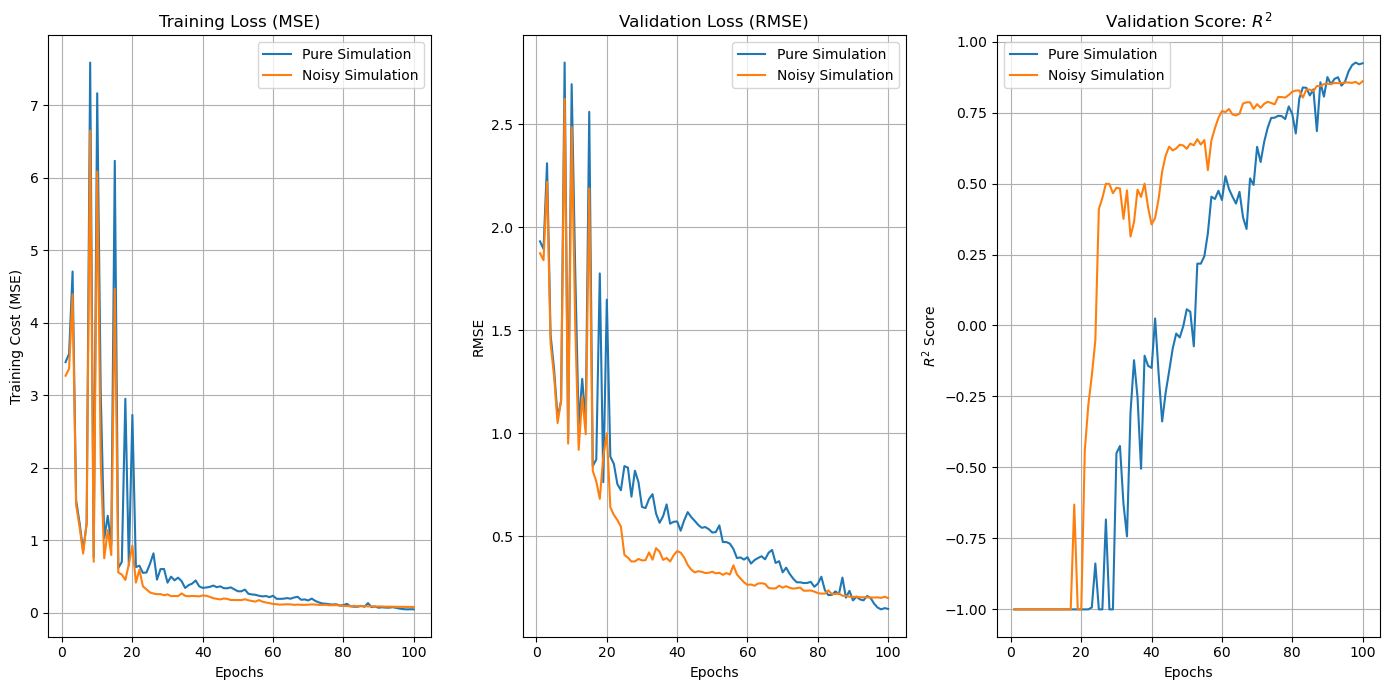

In [18]:
fig, ax = plt.subplots(1,3, figsize=(14,7))
for i, metric in enumerate(zip([cost_data_pure, rmse_pure, r2_score_pure_filtered], [cost_data_noisy, rmse_noisy, r2_score_noisy_filtered])):
    ax[i].plot(epoch_list, metric[0], label="Pure Simulation")
    ax[i].plot(epoch_list, metric[1], label="Noisy Simulation")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(["Training Cost (MSE)", "RMSE", "$R^2$ Score"][i])
    ax[i].set_title(["Training Loss (MSE)", "Validation Loss (RMSE)", "Validation Score: $R^2$"][i])
    ax[i].legend()
    ax[i].grid()
plt.tight_layout()
plt.show()

## Shutdown Parallel Initialization

In [19]:
nqc.shutdown()